In this tutorial, we will show how to use the [code](https://github.com/Microsoft/CNTK/blob/master/Examples/Image/Classification/ResNet/Python/TrainResNet_CIFAR10.py) in the Examples directory to evaluate the performance (i.e., time cost, loss, metric) of different learners (i.e., sgd, momentum_sgd, nesterov, adam) on the classification task of CIFAR-10 dataset using ResNet model.

The structure of this tutorial are organized as follows: we first introduce the CIFAR-10 dataset, ResNet model, and different learners. Then we will show how to use these learners during the training of ResNet model on the CIFAR-10 dataset, after which we will plot the time cost, loss, and metric trends by time.

## CIFAR-10

### Dataset

The CIFAR-10 dataset [2] contains 6k 32×32 color images for each of 10
classes, therefore there are 60k images in total. 

The 10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

Note that these classes are mutual exclusive.

The whole set is further divided into 5 training sets and 1 test set, with 10k
images for each. 

The test set contains exactly 1k for each class, while this condition
is not necessary for the training sets.

### Download

We can use this [script](https://github.com/Microsoft/CNTK/tree/master/Examples/Image/DataSets/CIFAR-10/install_cifar10.py)  to download the dataset. Simple run the following command in a terminal:

```bash
cd Examples/Image/DataSets/CIFAR-10
python install_cifar10.py
```

**Note**: Error is encountered when I run this script on my Ubuntu 17.04 64 bit machine, while it runs well on my Win10 64bit machine.

The tree structure of the whole dataset is as follows:
* `cifar-10-batches-py` includes 5 training batches and one test batch.
* `train` and `test`: include the 60k `.png` files.
* `train_map.txt` and `test_map.txt` maintain the location of each `.png` image and corresponding label.
* `Train_cntk_text.txt` and `Test_cntk_text.txt` have a label and corresponding features (pixel level, 32 * 32 * 3) for one image at each line.

In [1]:
import os

# Paths relative to current python file.
abs_path = os.path.dirname(os.path.abspath('__file__'))
data_path = os.path.join(abs_path, "..", "Examples", "Image", "DataSets", "CIFAR-10")

import sys
sys.path.append(data_path)

import cifar_utils as ut
print(data_path)

C:\repos\CNTK\Manual\..\Examples\Image\DataSets\CIFAR-10


In [2]:
if not os.path.exists(data_path + '/' + 'cifar-10-batches-py'):
    trn, tst= ut.loadData('http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz')

    print ('Writing train text file...')
    ut.saveTxt(data_path + '/Train_cntk_text.txt', trn)
    print ('Done.')
    print ('Writing test text file...')
    ut.saveTxt(data_path + '/Test_cntk_text.txt', tst)
    print ('Done.')
    
    print ('Converting train data to png images...')
    ut.saveTrainImages(data_path + '/Train_cntk_text.txt', data_path + '/train')
    print ('Done.')
    print ('Converting test data to png images...')
    ut.saveTestImages(data_path + '/Test_cntk_text.txt', data_path + '/test')
    print ('Done.')
    
    for name in ['test_map.txt', 'test_regrLabels.txt', 'train_map.txt', 'train_regrLabels.txt', 'cifar-10-batches-py']:
    
        if os.path.exists(data_path + '/' + name):
            continue
        os.rename(name, data_path + '/' + name)

## ResNet20

### Model

The residual network is described in Subsection 4.2 of the original paper [1]. Here we copy some sentences for integrity.

> The network inputs are 32×32 images, with
the per-pixel mean subtracted. The first layer is 3×3 convolutions.
Then we use a stack of 6n layers with 3×3 convolutions
on the feature maps of sizes {32, 16, 8} respectively,
with 2n layers for each feature map size. The numbers of
filters are {16, 32, 64} respectively. The subsampling is performed
by convolutions with a stride of 2. The network ends
with a global average pooling, a 10-way fully-connected
layer, and softmax. There are totally 6n+2 stacked weighted
layers. 

When n = 3, the number of layers is exactly 20.

**Note**: here a CPU-only cntk distribution will not apply.

### Implementation

In the main [code](https://github.com/Microsoft/CNTK/blob/master/Examples/Image/Classification/ResNet/Python/TrainResNet_CIFAR10.py), we can see this line of code
```
if network_name == 'resnet20':
    z = create_cifar10_model(graph_input, 3, num_classes)
    lr_per_mb = [1.0]*80 + [0.1]*40 + [0.01]
```

The `create_cifar10_model` details are accessible [here](https://github.com/Microsoft/CNTK/blob/master/Examples/Image/Classification/ResNet/Python/resnet_models.py).

## Learners

We compare four different learners here: sgd, momentum_sgd, nesterov, adam. 

An overview of gradient descent optimization algorithms can be found in [4].

## Train and Evaluate

Let us just copy and paste some code from [here](https://github.com/Microsoft/CNTK/blob/master/Examples/Image/Classification/ResNet/Python/TrainResNet_CIFAR10.py) so that we do not make wheels ourselves again.

In [3]:
%matplotlib inline

import os

# Paths relative to current python file.
abs_path = os.path.dirname(os.path.abspath('__file__'))
code_path = os.path.join(abs_path, "..", "Examples", "Image", "Classification", "ResNet", "Python")

code_path
import sys
sys.path.append(code_path)

from TrainResNet_CIFAR10 import *

We define some variables that will be used in our training process, rather than input by command line parameters.

* `epochs`: how many times we go through the whole training set
* `epoch_size`: how many instances we use in our training set

In [4]:
network_name = 'resnet20'

model_dir = os.path.join(abs_path, "Models")

epochs = 160
epoch_size = 50000
epochs = 16 # FIXME: we use a small training set to save time, comment this line out when you do experiment yourself.
epoch_size = 1000 

The loss and metric used in the sample code is shown in:

```
        # loss and metric
        ce = cross_entropy_with_softmax(z, graph_label)
        pe = classification_error(z, graph_label)
```

The learner in the original code is set fixed as `momentum_sgd`:

```
    # trainer object
    learner = momentum_sgd(z.parameters, lr_schedule, mm_schedule,
                           l2_regularization_weight=l2_reg_weight)
    trainer = Trainer(z, (ce, pe), learner, progress_writers)
```    

So we need to do a simple modification of the `train_and_evaluate` function to add a new parameter called `learner` to make our life easier.

In [5]:
from cntk.learners import adam, nesterov, sgd, momentum_sgd, learning_rate_schedule, momentum_as_time_constant_schedule, UnitType
# Train and evaluate the network.
def train_and_evaluate(reader_train, reader_test, network_name, epoch_size, max_epochs, learner, profiler_dir=None,
                       model_dir=None, log_dir=None, tensorboard_logdir=None, gen_heartbeat=False, fp16=False):

    set_computation_network_trace_level(0)

    # Input variables denoting the features and label data
    input_var = C.input_variable((num_channels, image_height, image_width), name='features')
    label_var = C.input_variable((num_classes))

    dtype = np.float16 if fp16 else np.float32
    if fp16:
        graph_input = C.cast(input_var, dtype=np.float16)
        graph_label = C.cast(label_var, dtype=np.float16)
    else:
        graph_input = input_var
        graph_label = label_var

    with C.default_options(dtype=dtype):
        # create model, and configure learning parameters
        if network_name == 'resnet20':
            z = create_cifar10_model(graph_input, 3, num_classes)
            lr_per_mb = [1.0]*80 + [0.1]*40 + [0.01]
        elif network_name == 'resnet110':
            z = create_cifar10_model(graph_input, 18, num_classes)
            lr_per_mb = [0.1]*1 + [1.0]*80 + [0.1]*40 + [0.01]
        else:
            raise RuntimeError("Unknown model name!")

        # loss and metric
        ce = cross_entropy_with_softmax(z, graph_label)
        pe = classification_error(z, graph_label)

    if fp16:
        ce = C.cast(ce, dtype=np.float32)
        pe = C.cast(pe, dtype=np.float32)

    # shared training parameters
    minibatch_size = 128
    l2_reg_weight = 0.0001

    # Set learning parameters
    lr_per_sample = [lr/minibatch_size for lr in lr_per_mb]
    lr_schedule = learning_parameter_schedule_per_sample(lr_per_sample, epoch_size=epoch_size)
    mm_schedule = momentum_schedule(0.9, minibatch_size)

    # progress writers
    progress_writers = [ProgressPrinter(tag='Training', log_to_file="{}{}.log".format(log_dir,learner), num_epochs=max_epochs, gen_heartbeat=gen_heartbeat)]
    tensorboard_writer = None
    if tensorboard_logdir is not None:
        tensorboard_writer = TensorBoardProgressWriter(freq=10, log_dir=tensorboard_logdir, model=z)
        progress_writers.append(tensorboard_writer)

    print(learner)
    # trainer object
    if learner == 'sgd':
        learner = sgd(z.parameters, lr_schedule, 
                      l2_regularization_weight = l2_reg_weight)
    elif learner == 'momentum_sgd':
        learner = momentum_sgd(z.parameters, lr_schedule, mm_schedule,
                               l2_regularization_weight=l2_reg_weight)
    elif learner == 'nesterov':
        learner = nesterov(z.parameters, lr_schedule, mm_schedule,
                           l2_regularization_weight = l2_reg_weight)
    elif learner == 'adam':
        learner = adam(z.parameters, lr_schedule, mm_schedule,
                       l2_regularization_weight = l2_reg_weight)                      
        
    trainer = Trainer(z, (ce, pe), learner, progress_writers)

    # define mapping from reader streams to network inputs
    input_map = {
        input_var: reader_train.streams.features,
        label_var: reader_train.streams.labels
    }

    log_number_of_parameters(z) ; print()

    # perform model training
    if profiler_dir:
        start_profiler(profiler_dir, True)

    for epoch in range(max_epochs):       # loop over epochs
        sample_count = 0
        while sample_count < epoch_size:  # loop over minibatches in the epoch
            data = reader_train.next_minibatch(min(minibatch_size, epoch_size-sample_count), input_map=input_map) # fetch minibatch.
            trainer.train_minibatch(data)                                   # update model with it
            sample_count += trainer.previous_minibatch_sample_count         # count samples processed so far

        trainer.summarize_training_progress()

        # Log mean of each parameter tensor, so that we can confirm that the parameters change indeed.
        if tensorboard_writer:
            for parameter in z.parameters:
                tensorboard_writer.write_value(parameter.uid + "/mean", reduce_mean(parameter).eval(), epoch)

        if model_dir:
            z.save(os.path.join(model_dir, network_name + "_{}.dnn".format(epoch)))
        enable_profiler() # begin to collect profiler data after first epoch

    if profiler_dir:
        stop_profiler()

    # Evaluation parameters
    test_epoch_size = 100 # 10000
    minibatch_size = 16

    # process minibatches and evaluate the model
    metric_numer = 0
    metric_denom = 0
    sample_count = 0

    while sample_count < test_epoch_size:
        current_minibatch = min(minibatch_size, test_epoch_size - sample_count)
        # Fetch next test min batch.
        data = reader_test.next_minibatch(current_minibatch, input_map=input_map)
        # minibatch data to be trained with
        metric_numer += trainer.test_minibatch(data) * current_minibatch
        metric_denom += current_minibatch
        # Keep track of the number of samples processed so far.
        sample_count += data[label_var].num_samples

    print("")
    trainer.summarize_test_progress()
    print("")

    return metric_numer/metric_denom

In [6]:
log_dir='log/'

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

learners = ['adam', 'momentum_sgd', 'nesterov', 'sgd']
for learner in learners:
    reader_train = create_image_mb_source(os.path.join(data_path, 'train_map.txt'), os.path.join(data_path, 'CIFAR-10_mean.xml'), True, total_number_of_samples=epochs * epoch_size)
    reader_test = create_image_mb_source(os.path.join(data_path, 'test_map.txt'), os.path.join(data_path, 'CIFAR-10_mean.xml'), False, total_number_of_samples=C.io.FULL_DATA_SWEEP)
    train_and_evaluate(reader_train, reader_test, network_name, epoch_size, epochs, learner=learner, model_dir=model_dir, log_dir=log_dir)

C:\local\Anaconda3-4.1.1-Windows-x86_64\lib\site-packages\cntk\learners\__init__.py:340: RuntimeWarning: When providing the schedule as a number, epoch_size is ignored
  warnings.warn('When providing the schedule as a number, epoch_size is ignored', RuntimeWarning)


Redirecting log to file log/adam.log
adam
Training 272474 parameters in 65 parameter tensors.



Redirecting log to file log/momentum_sgd.log
momentum_sgd
Training 272474 parameters in 65 parameter tensors.



Redirecting log to file log/nesterov.log
nesterov
Training 272474 parameters in 65 parameter tensors.



Redirecting log to file log/sgd.log
sgd
Training 272474 parameters in 65 parameter tensors.





Now all the logs will be written into the file `sgd.log`. Then we want to parse the raw log content to some stuctured format, so that we can plot a picture based on the numbers, which is more insightful for human like us. We define the function like this:

In [7]:
import re

def parse_line(line):
    '''
    input: Finished Epoch[150 of 160]: [Training] loss = 0.027842 * 50000, metric = 0.82% * 50000 29.980s (1667.8 samples/s);
    output: 0.027842, 0.82, 29.980
    '''
    m = re.match(r"Finished Epoch\[(.+) of {}\]: \[Training\] loss = (.+) \* {}, metric = (.+)% \* {} (.+)s \((.+) samples/s\);".format(epochs, epoch_size, epoch_size), 
                 line.strip())
    if m:
        return map(float, [m.group(2), m.group(3), m.group(4)])
    return None, None, None

def parse_file(file_name):
    '''
    input: the log file generated by cntk.logging when training ResNet-20
    output: three arrays, corresponding to the loss, metric, time of each epoch
    '''
    loss = []
    metric = []
    time = []
    
    with open(file_name) as f:
        line = f.readline()
        while line:
            l, m, t = parse_line(line)
            line = f.readline()
            if l == None:
                continue
            loss.append(l)
            metric.append(m)
            time.append(t)  
    return loss, metric, time

After we distill the numbers out of the target log file, we can use `matplotlib` to draw a picture:

In [8]:
import matplotlib.pyplot as plt

def plot(losses, labels, title):
    plt.clf()
    colors = ['r','g','b', 'y']
    for i, loss in enumerate(losses):
        x = range(len(loss))
        plt.plot(x, loss, color=colors[i], label=labels[i])
    # plt.savefig(img_file + '.png')
    plt.legend()
    plt.title(title) 
    plt.show()

The whole main function looks as follows:

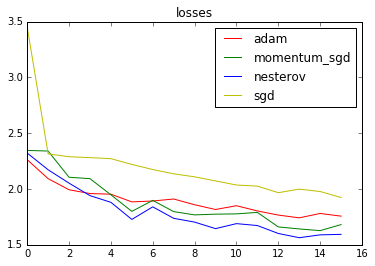

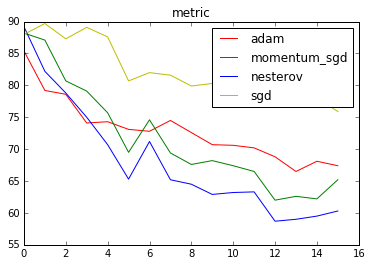

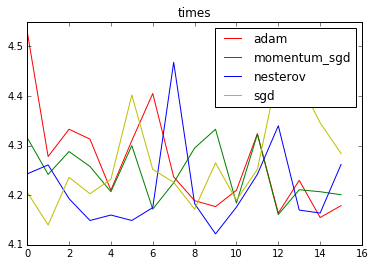

In [9]:
log_files = ['log/{}.log'.format(learner) for learner in learners]

losses = [None]*len(log_files)
metrics = [None]*len(log_files)
times = [None]*len(log_files)
for i, log_file in enumerate(log_files):
    losses[i], metrics[i], times[i] = parse_file(log_file)

plot(losses, learners, 'losses')
plot(metrics, learners, 'metric')
plot(times, learners, 'times')                

We can see that the performace indicate that under this task and this dataset, the learners `nesterov > momentum_sgd > adam > sgd`, while the time spent for each epoch display a reversed order.

## Conclusion



In this manual, we introduced the CIFAR-10 dataset and the esNet model, we then use different learners to optimize the model parameters and show the history of training process. After dipecting some graphs, we can see nesterov learner performs best among the several learners we picked.

## References

[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. Deep residual
learning for image recognition. In Proceedings of the IEEE Conference on
Computer Vision and Pattern Recognition, pages 770–778, 2016.

[2] Alex Krizhevsky and Geoffrey Hinton. Learning multiple layers of features 
from tiny images. 2009

[3] Matthew D Zeiler. Adadelta: an adaptive learning rate method. arXiv
preprint arXiv:1212.5701, 2012.

[4] Ruder, Sebastian. "An overview of gradient descent optimization algorithms." arXiv preprint arXiv:1609.04747 (2016).